In [1]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from utils import load_file
from evals import evaluate,evaluate_mae_with_confidence,influence
from evals import euclidean_distance, manhattan_distance, pairwise_euclidean_distance, accumulated_proximity, full_accumulated_proximity

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [2]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5","1_0","1_1","1_2","1_3","1_4","1_5","2_0","2_1","2_2","2_3","2_4","2_5","3_0","3_1","3_2","3_3","3_4","3_5"]

In [7]:
global_model = ShallowNN(features)
global_model.load_state_dict(torch.load('checkpt/saving/epoch_500/_fedl_global_20_25.pth'))

<All keys matched successfully>

In [8]:
modified_model = ShallowNN(features)
modified_model.load_state_dict(torch.load('checkpt/saving_only_selected_clients/epoch_500/_fedl_global_20_25.pth'))

<All keys matched successfully>

In [10]:
eval_list = []
for client in client_ids:
    val_data_path =  "testpt/"+str(client)+".pt"
    val_set = torch.load(val_data_path)
    val_loader = DataLoader(val_set, batch_size, shuffle = True)
    
    isolated_model_path = "checkpt/epoch_500/isolated/batch64_client_"+str(client)+".pth"
    isolated_model =  ShallowNN(features)
    isolated_model.load_state_dict(torch.load(isolated_model_path))
    
    isolated_mae,(iso_lower_band, iso_upper_band), _  = evaluate_mae_with_confidence(isolated_model, val_loader)
    federated_mae,(fed_lower_band, fed_upper_band), _ = evaluate_mae_with_confidence(global_model, val_loader)
    modified_mae,(mod_lower_band, mod_upper_band), _ = evaluate_mae_with_confidence(modified_model, val_loader)
    
    eval_dict = {"client_id":client, "Isolated Average MAE": round(isolated_mae, 4),
                 "Isolated MAE lower band":round(iso_lower_band,4),
                 "Isolated MAE upper band":round(iso_upper_band,4),
                 "Federated Average MAE" :round(federated_mae, 4),
                "Federated MAE lower band": round(fed_lower_band, 4),
                "Federated MAE upper band":round(fed_upper_band,4),
                "Modified model Average MAE" :round(modified_mae, 4),
                "Modified model MAE lower band": round(mod_lower_band, 4),
                "Modified model MAE upper band":round(mod_upper_band,4)}
    eval_list.append(eval_dict)
    #print(client,eval_dict)
eval_df = pd.DataFrame.from_dict(eval_list)
eval_df["clients"] = [i for i in range(1,25)] 

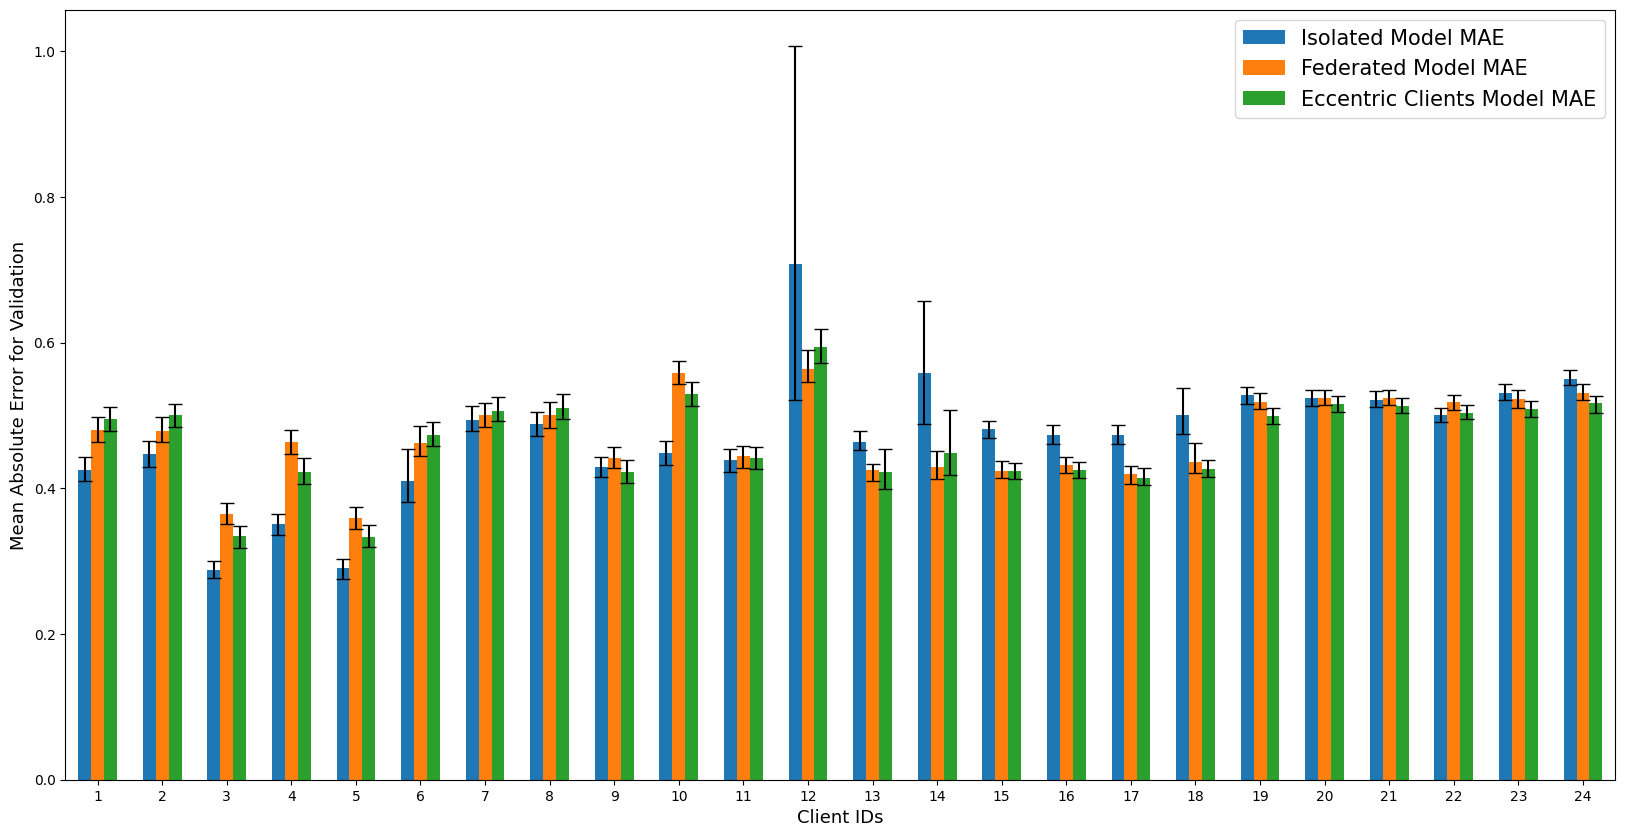

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
bar_width = 0.2  # Decrease the bar width
index = np.arange(len(eval_df))

bar1 = ax.bar(index - bar_width, eval_df['Isolated Average MAE'], bar_width, yerr=[
    (eval_df["Isolated Average MAE"] - eval_df["Isolated MAE lower band"]),
    (eval_df['Isolated MAE upper band'] - eval_df["Isolated Average MAE"])
], capsize=5, label='Isolated Model MAE')

bar2 = ax.bar(index, eval_df['Federated Average MAE'], bar_width, yerr=[
    (eval_df["Federated Average MAE"] - eval_df["Federated MAE lower band"]),
    (eval_df['Federated MAE upper band'] - eval_df["Federated Average MAE"])
], capsize=5, label='Federated Model MAE')

bar3 = ax.bar(index + bar_width, eval_df['Modified model Average MAE'], bar_width, yerr=[
    (eval_df["Modified model Average MAE"] - eval_df["Modified model MAE lower band"]),
    (eval_df['Modified model MAE upper band'] - eval_df["Modified model Average MAE"])
], capsize=5, label='Eccentric Clients Model MAE')

ax.set_xlabel('Client IDs', fontdict={'fontsize': 13})
ax.set_ylabel("Mean Absolute Error for Validation", fontdict={'fontsize': 13})
ax.set_xticks(index)
ax.set_xticklabels(eval_df['clients'])
ax.legend(fontsize=15, loc="upper right")

# Adjust the xlim to decrease space at the left and right edges
ax.set_xlim(index[0] - 0.5, index[-1] + 0.5)

plt.show()
